# Etapa de Modelagem do TCC

O modelo de previsão de rentabilidade de filmes foi feito usando duas técnicas diferentes (**Random Forest** e **Light GBM**) a partir de 4 hipóteses, cada uma usando uma variável alvo diferente. 

	1- Worldwide gross
    
	2- ROI ((worldwide_gross - budget)/budget)
    
	3- Domestic gross
    
	4- Number of tickets (domestic_gross/preço_Ticket)

<br><br>

## Carregando dos dados e das bibliotecas

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
import math
import random
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import GridSearchCV

In [2]:
filmes = pd.read_csv('db_filmes.csv', sep=';')

In [ ]:
filmes.info()

In [4]:
# Carregamento de todas as features e das variáveis alvo
filmes_x = filmes[['runtime', 'release_month', 'budget', 'age_rating', 'genre_drama', 'genre_comedy', 
                    'genre_thriller', 'genre_action', 'genre_adventure', 'genre_romance', 'genre_crime', 
                    'genre_fantasy', 'genre_family', 'genre_scifi', 'genre_mystery', 'genre_horror', 'genre_other', 
                    'language_english', 'language_spanish', 'language_french', 'language_other', 
                    'weekday_friday', 'weekday_wednesday', 'weekday_thursday', 'weekday_other']].copy()
filmes_y = filmes[['worldwide_gross', 'domestic_gross', 'roi', 'tickets_sold']].copy()

<br><br>

# Hipótese 1: *worldwide_gross*

In [63]:
X, y = filmes_x, filmes_y['worldwide_gross']
print("Shape X", X.shape)
print("Shape y", y.shape)

seed=10
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25)

print()
print("Training set X", X_training.shape)
print("Training set X", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Shape X (2668, 25)
Shape y (2668,)

Training set X (2001, 25)
Training set X (2001,)
Test set X (667, 25)
Test set y (667,)


<br>

## Hip.1: Random Forest

In [7]:
# Random Forest com Cross Validation e Grid Search

# Define os valores possíveis para cada um dos parâmetros a ser testados no Grid Search
params = {'n_estimators': [5, 35, 40, 45, 50, 55, 60],
          'max_features': [14, 15, 16, 17, 18, 19],
          'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 20, 30],
          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 15, 30],}

# Cria um objeto de modelo usando RandomForestRegressor
rf_model_cv_gs_v1 = RandomForestRegressor()

# Cria um objeto de grid search com usando GridSearchCV
grid_search_v1 = GridSearchCV(rf_model_cv_gs_v1, param_grid=params, scoring='r2', return_train_score=True) #default value for splitting is 3

# Treina o modelo com o grid search
grid_search_v1.fit(X_training, y_training)

# Imprime a melhor combinação de hiperparâmetros identificados na busca
print('\n Best hyperparameters:')
print(grid_search_v1.best_params_)

# Pega cv_results do grid search
cv_results_v1 = pd.DataFrame(grid_search_v1.cv_results_)

# Imprime Score médio nos conjuntos de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v1[cv_results_v1.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v1[cv_results_v1.rank_test_score == 1].std_train_score.values[0]))
# Imprime Score médio nos conjuntos de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v1[cv_results_v1.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v1[cv_results_v1.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'max_depth': 7, 'max_features': 14, 'min_samples_split': 2, 'n_estimators': 40}
Average Score on train set: 0.816 +/- 0.006
Average Score on validation set: 0.632 +/- 0.058


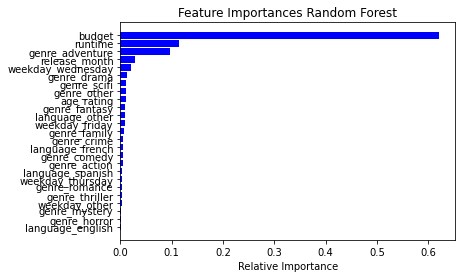

In [64]:
# Define os parâmetros do objeto de modelo para os melhores parâmetros identificados na busca
rf_model_cv_gs_v1.set_params(n_estimators = grid_search_v1.best_params_['n_estimators'],
                           max_features = grid_search_v1.best_params_['max_features'],
                           max_depth = grid_search_v1.best_params_['max_depth'],
                           min_samples_split = grid_search_v1.best_params_['min_samples_split'])


# Treina o modelo usando os melhores parâmetros identificados
rf_model_cv_gs_v1.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = rf_model_cv_gs_v1.feature_importances_
indices = np.argsort(importances)

# Gera gráfico de Feature Importance
plt.title('Feature Importances Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

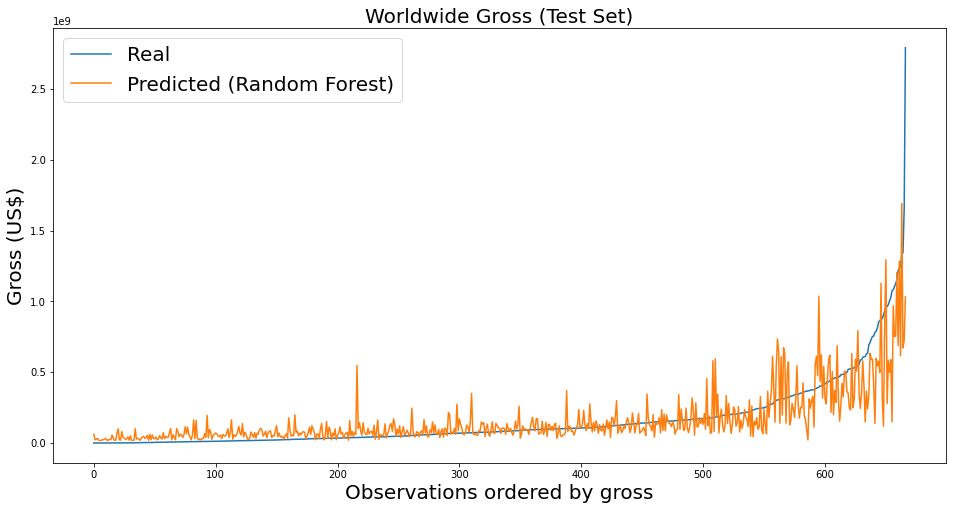

In [9]:
# Plotagem de valores previstos vs. valores reais (para avaliar visualmente o modelo)
y_pred_v1 = rf_model_cv_gs_v1.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('Worldwide Gross (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'RF':rf_model_cv_gs_v1.predict(X_test)})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Random Forest)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [10]:
#print("Explained variance score: {:.3f}".format(explained_variance_score(y_test, y_pred_v1)))
#print("Mean absolute error (MAE): {:.3f}".format(mean_absolute_error(y_test, y_pred_v1)))
#print("Mean squared error (MSE): {:.3f}".format(mean_squared_error(y_test, y_pred_v1)))
#print("Mean squared log error (MSLE): {:.3f}".format(mean_squared_log_error(y_test, y_pred_v1)))

# Imprime o Score R-quadrado do conjunto de teste
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v1)))

R² Score: 0.613


<br>

## Hip.1: Light GBM

In [ ]:
# Random Forest com Cross Validation e Grid Search para Light GBM

# Define os valores possíveis para cada hiperparâmetro a ser testado
params = {'max_depth': [2, 5, 10, 30],
          'learning_rate': [0.01, 0.03, 0.1, 0.5],
          'n_estimators': [50, 100, 200, 500],
          'min_child_samples': [5, 20, 50],
          'min_split_gain': [0., 0.5, 1, 5],
          'num_leaves': [31, 20, 40] }

# create model object with LGBMRegressor
lgb_model_cv_gs_v1 = lgb.LGBMRegressor(verbose=-1)

# create grid search object with GridSearchCV
grid_search_v1_lgb = GridSearchCV(lgb_model_cv_gs_v1, param_grid=params, scoring='r2', return_train_score=True)

# train the model with grid search
grid_search_v1_lgb.fit(X_training, y_training)

In [38]:
# Imprime a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search_v1_lgb.best_params_)

# get cv_results
cv_results_v1_lgb = pd.DataFrame(grid_search_v1_lgb.cv_results_)

# print average Score on train sets
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v1_lgb[cv_results_v1_lgb.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v1_lgb[cv_results_v1_lgb.rank_test_score == 1].std_train_score.values[0]))
# print average Score on validation sets
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v1_lgb[cv_results_v1_lgb.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v1_lgb[cv_results_v1_lgb.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'learning_rate': 0.03, 'max_depth': 10, 'min_child_samples': 20, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 20}
Average Score on train set: 0.726 +/- 0.011
Average Score on validation set: 0.601 +/- 0.047


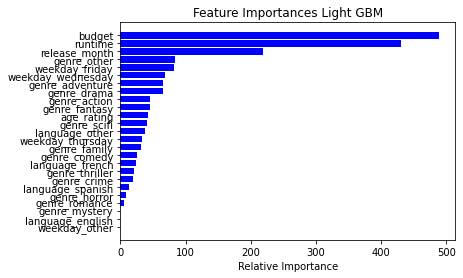

In [66]:
# Define os hiperparâmetros para os melhores identificados
lgb_model_cv_gs_v1.set_params(learning_rate = grid_search_v1_lgb.best_params_['learning_rate'],
                           max_depth = grid_search_v1_lgb.best_params_['max_depth'],
                           min_child_samples = grid_search_v1_lgb.best_params_['min_child_samples'],
                           min_split_gain = grid_search_v1_lgb.best_params_['min_split_gain'],
                           n_estimators = grid_search_v1_lgb.best_params_['n_estimators'],
                           num_leaves = grid_search_v1_lgb.best_params_['num_leaves'])


# train a model using the best parameters
lgb_model_cv_gs_v1.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = lgb_model_cv_gs_v1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances Light GBM')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

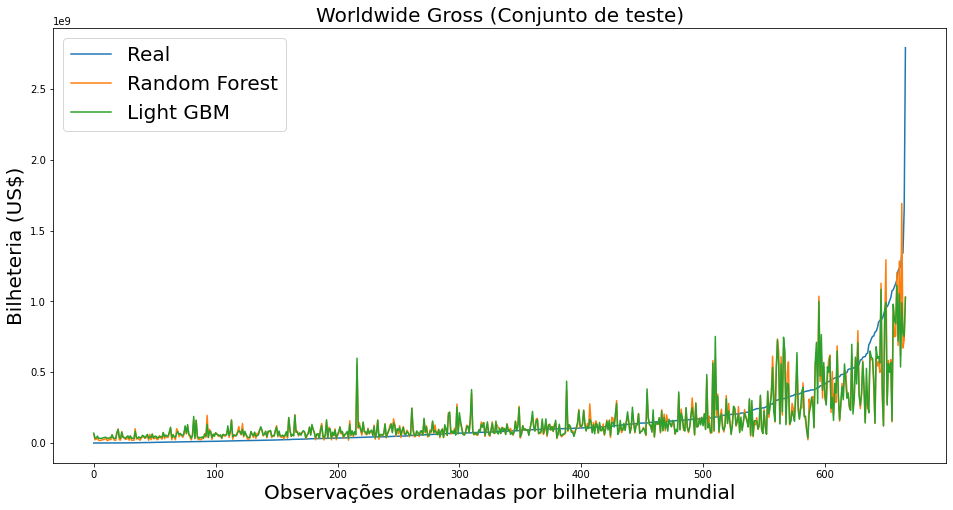

In [69]:
# Plotting predicted values vs real values
y_pred_v1_lgb = lgb_model_cv_gs_v1.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('Worldwide Gross (Conjunto de teste)',fontsize=20)
df = pd.DataFrame({'real':y_test,'RF':y_pred_v1, 'LGBM':y_pred_v1_lgb})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Random Forest', 'Light GBM'],fontsize=20)
plt.ylabel('Bilheteria (US$)',fontsize=20)
plt.xlabel('Observações ordenadas por bilheteria mundial',fontsize=20)
plt.show()

In [41]:
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v1_lgb)))

R² Score: 0.618


<br><br>

# Hipótese 2: *ROI*

In [44]:
X, y = filmes_x, filmes_y['roi']
print("Shape X", X.shape)
print("Shape y", y.shape)

seed=10
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25)

print()
print("Training set X", X_training.shape)
print("Training set X", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Shape X (2668, 25)
Shape y (2668,)

Training set X (2001, 25)
Training set X (2001,)
Test set X (667, 25)
Test set y (667,)


<br>

## Hip.2: Random Forest

In [11]:
# Random Forest com Cross Validation e Grid Search

# Define os valores possíveis para cada um dos parâmetros a ser testados no Grid Search
params = {'n_estimators': [5, 35, 40, 45, 50, 55, 60],
          'max_features': [14, 15, 16, 17, 18, 19],
          'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 20, 30],
          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 15, 30],}

# Cria um objeto de modelo usando RandomForestRegressor
rf_model_cv_gs_v2 = RandomForestRegressor()

# Cria um objeto de grid search com usando GridSearchCV
grid_search_v2 = GridSearchCV(rf_model_cv_gs_v2, param_grid=params, scoring='r2', return_train_score=True) #default value for splitting is 3

# Treina o modelo com o grid search
grid_search_v2.fit(X_training, y_training)

# Imprime a melhor combinação de hiperparâmetros identificados na busca
print('\n Best hyperparameters:')
print(grid_search_v2.best_params_)

# Pega cv_results do grid search
cv_results_v2 = pd.DataFrame(grid_search_v2.cv_results_)

# Imprime Score médio nos conjuntos de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v2[cv_results_v2.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v2[cv_results_v2.rank_test_score == 1].std_train_score.values[0]))
# Imprime Score médio nos conjuntos de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v2[cv_results_v2.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v2[cv_results_v2.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'max_depth': 6, 'max_features': 15, 'min_samples_split': 5, 'n_estimators': 50}
Average Score on train set: 0.768 +/- 0.009
Average Score on validation set: 0.622 +/- 0.057


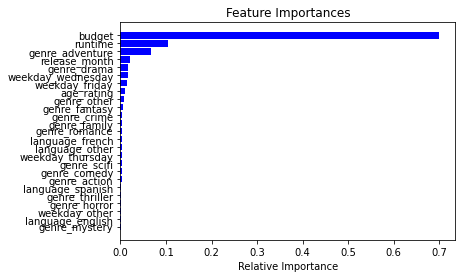

In [12]:
# Define os parâmetros do objeto de modelo para os melhores parâmetros identificados na busca
rf_model_cv_gs_v2.set_params(n_estimators = grid_search_v2.best_params_['n_estimators'],
                           max_features = grid_search_v2.best_params_['max_features'],
                           max_depth = grid_search_v2.best_params_['max_depth'],
                           min_samples_split = grid_search_v2.best_params_['min_samples_split'])


# Treina o modelo usando os melhores parâmetros identificados
rf_model_cv_gs_v2.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = rf_model_cv_gs_v2.feature_importances_
indices = np.argsort(importances)

# Gera gráfico de Feature Importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

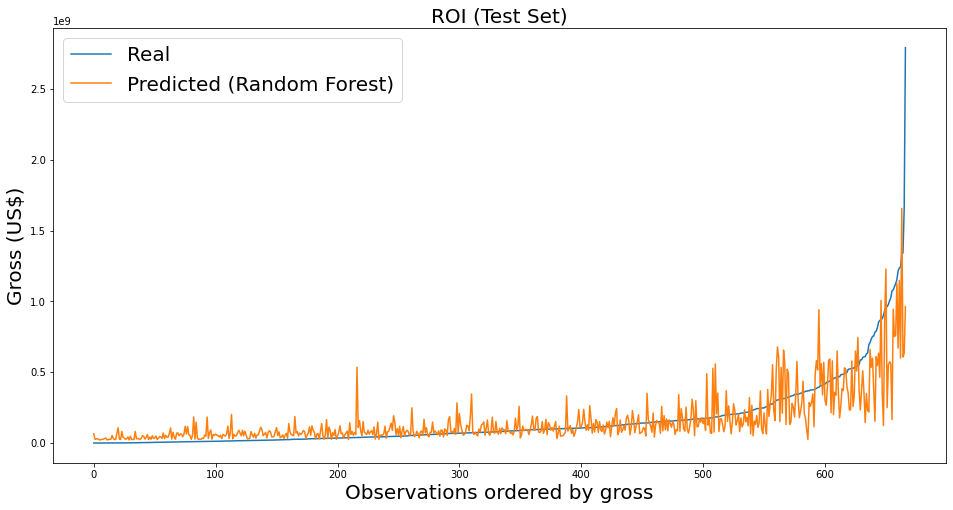

In [15]:
# Plotagem de valores previstos vs. valores reais (para avaliar visualmente o modelo)
y_pred_v2 = rf_model_cv_gs_v2.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('ROI (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'RF':rf_model_cv_gs_v2.predict(X_test)})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Random Forest)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [16]:
# Imprime o Score R-quadrado do conjunto de teste
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v2)))

R² Score: 0.613


<br>

## Hip.2: Light GBM

In [ ]:
# Random Forest com Cross Validation e Grid Search para Light GBM

# Define os valores possíveis para cada hiperparâmetro a ser testado
params = {'max_depth': [2, 5, 10, 30],
          'learning_rate': [0.01, 0.03, 0.1, 0.5],
          'n_estimators': [50, 100, 200, 500],
          'min_child_samples': [5, 20, 50],
          'min_split_gain': [0., 0.5, 1, 5],
          'num_leaves': [31, 20, 40] }

# create model object with LGBMRegressor
lgb_model_cv_gs_v2 = lgb.LGBMRegressor(verbose=-1)

# create grid search object with GridSearchCV
grid_search_v2_lgb = GridSearchCV(lgb_model_cv_gs_v2, param_grid=params, scoring='r2', return_train_score=True)

# train the model with grid search
grid_search_v2_lgb.fit(X_training, y_training)

In [46]:
# Imprime a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search_v2_lgb.best_params_)

# get cv_results
cv_results_v2_lgb = pd.DataFrame(grid_search_v2_lgb.cv_results_)

# print average Score on train sets
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v2_lgb[cv_results_v2_lgb.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v2_lgb[cv_results_v2_lgb.rank_test_score == 1].std_train_score.values[0]))
# print average Score on validation sets
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v2_lgb[cv_results_v2_lgb.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v2_lgb[cv_results_v2_lgb.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_split_gain': 0.0, 'n_estimators': 500, 'num_leaves': 31}
Average Score on train set: 0.795 +/- 0.005
Average Score on validation set: 0.686 +/- 0.025


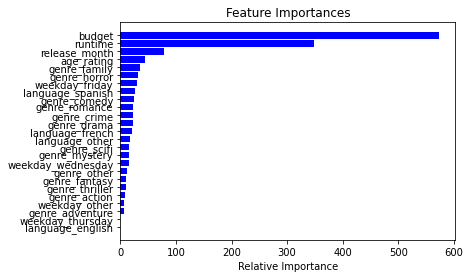

In [47]:
# Define os hiperparâmetros para os melhores identificados
lgb_model_cv_gs_v2.set_params(learning_rate = grid_search_v2_lgb.best_params_['learning_rate'],
                           max_depth = grid_search_v2_lgb.best_params_['max_depth'],
                           min_child_samples = grid_search_v2_lgb.best_params_['min_child_samples'],
                           min_split_gain = grid_search_v2_lgb.best_params_['min_split_gain'],
                           n_estimators = grid_search_v2_lgb.best_params_['n_estimators'],
                           num_leaves = grid_search_v2_lgb.best_params_['num_leaves'])


# train a model using the best parameters
lgb_model_cv_gs_v2.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = lgb_model_cv_gs_v2.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

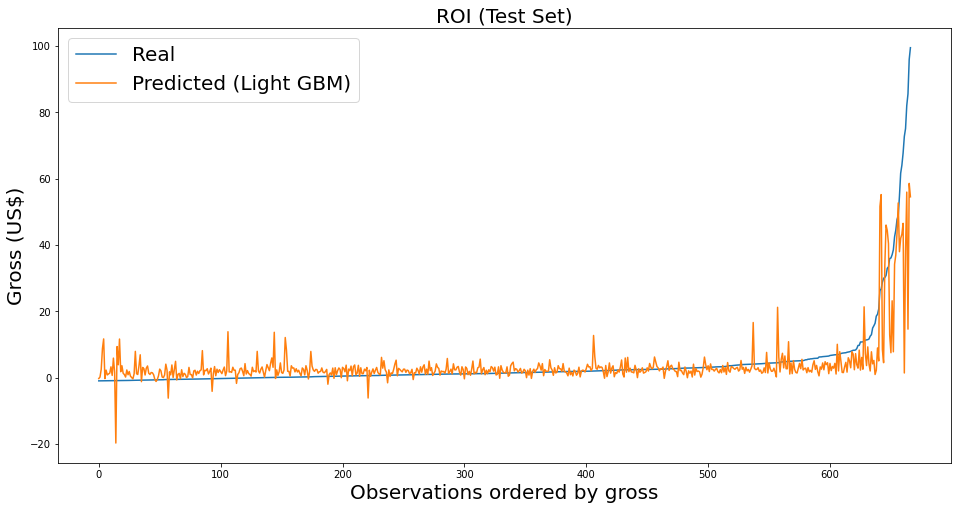

In [48]:
# Plotting predicted values vs real values
y_pred_v2_lgb = lgb_model_cv_gs_v2.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('ROI (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'LGBM':y_pred_v2_lgb})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Light GBM)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [49]:
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v2_lgb)))

R² Score: 0.622


<br><br>

# Hipótese 3: *domestic_gross*

In [50]:
X, y = filmes_x, filmes_y['domestic_gross']
print("Shape X", X.shape)
print("Shape y", y.shape)

seed=10
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25)

print()
print("Training set X", X_training.shape)
print("Training set X", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Shape X (2668, 25)
Shape y (2668,)

Training set X (2001, 25)
Training set X (2001,)
Test set X (667, 25)
Test set y (667,)


<br>

## Hip.3: Random Forest

In [22]:
# Random Forest com Cross Validation e Grid Search

# Define os valores possíveis para cada um dos parâmetros a ser testados no Grid Search
params = {'n_estimators': [5, 35, 40, 45, 50, 55, 60],
          'max_features': [14, 15, 16, 17, 18, 19],
          'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 20, 30],
          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 15, 30],}

# Cria um objeto de modelo usando RandomForestRegressor
rf_model_cv_gs_v3 = RandomForestRegressor()

# Cria um objeto de grid search com usando GridSearchCV
grid_search_v3 = GridSearchCV(rf_model_cv_gs_v3, param_grid=params, scoring='r2', return_train_score=True) #default value for splitting is 3

# Treina o modelo com o grid search
grid_search_v3.fit(X_training, y_training)

# Imprime a melhor combinação de hiperparâmetros identificados na busca
print('\n Best hyperparameters:')
print(grid_search_v3.best_params_)

# Pega cv_results do grid search
cv_results_v3 = pd.DataFrame(grid_search_v3.cv_results_)

# Imprime Score médio nos conjuntos de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v3[cv_results_v3.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v3[cv_results_v3.rank_test_score == 1].std_train_score.values[0]))
# Imprime Score médio nos conjuntos de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v3[cv_results_v3.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v3[cv_results_v3.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'max_depth': 9, 'max_features': 14, 'min_samples_split': 7, 'n_estimators': 50}
Average Score on train set: 0.768 +/- 0.009
Average Score on validation set: 0.622 +/- 0.057


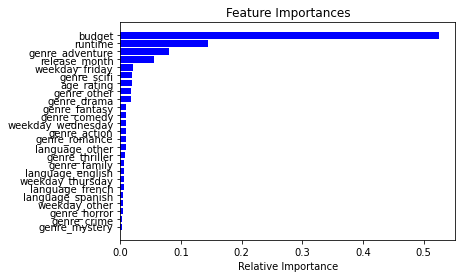

In [23]:
# Define os parâmetros do objeto de modelo para os melhores parâmetros identificados na busca
rf_model_cv_gs_v3.set_params(n_estimators = grid_search_v3.best_params_['n_estimators'],
                           max_features = grid_search_v3.best_params_['max_features'],
                           max_depth = grid_search_v3.best_params_['max_depth'],
                           min_samples_split = grid_search_v3.best_params_['min_samples_split'])


# Treina o modelo usando os melhores parâmetros identificados
rf_model_cv_gs_v3.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = rf_model_cv_gs_v3.feature_importances_
indices = np.argsort(importances)

# Gera gráfico de Feature Importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Plotagem de valores previstos vs. valores reais (para avaliar visualmente o modelo)
y_pred_v3 = rf_model_cv_gs_v3.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('Domestic Gross (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'RF':rf_model_cv_gs_v3.predict(X_test)})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Random Forest)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [25]:
# Imprime o Score R-quadrado do conjunto de teste
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v3)))

R² Score: 0.552


<br>

## Hip.3: Light GBM

In [ ]:
# Random Forest com Cross Validation e Grid Search para Light GBM

# Define os valores possíveis para cada hiperparâmetro a ser testado
params = {'max_depth': [2, 5, 10, 30],
          'learning_rate': [0.01, 0.03, 0.1, 0.5],
          'n_estimators': [50, 100, 200, 500],
          'min_child_samples': [5, 20, 50],
          'min_split_gain': [0., 0.5, 1, 5],
          'num_leaves': [31, 20, 40] }

# create model object with LGBMRegressor
lgb_model_cv_gs_v3 = lgb.LGBMRegressor(verbose=-1)

# create grid search object with GridSearchCV
grid_search_v3_lgb = GridSearchCV(lgb_model_cv_gs_v3, param_grid=params, scoring='r2', return_train_score=True)

# train the model with grid search
grid_search_v3_lgb.fit(X_training, y_training)

In [52]:
# Imprime a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search_v3_lgb.best_params_)

# get cv_results
cv_results_v3_lgb = pd.DataFrame(grid_search_v3_lgb.cv_results_)

# print average Score on train sets
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v3_lgb[cv_results_v3_lgb.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v3_lgb[cv_results_v3_lgb.rank_test_score == 1].std_train_score.values[0]))
# print average Score on validation sets
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v3_lgb[cv_results_v3_lgb.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v3_lgb[cv_results_v3_lgb.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'learning_rate': 0.03, 'max_depth': 10, 'min_child_samples': 20, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 31}
Average Score on train set: 0.672 +/- 0.009
Average Score on validation set: 0.499 +/- 0.034


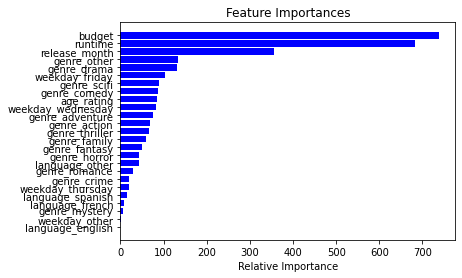

In [53]:
# Define os hiperparâmetros para os melhores identificados
lgb_model_cv_gs_v3.set_params(learning_rate = grid_search_v3_lgb.best_params_['learning_rate'],
                           max_depth = grid_search_v3_lgb.best_params_['max_depth'],
                           min_child_samples = grid_search_v3_lgb.best_params_['min_child_samples'],
                           min_split_gain = grid_search_v3_lgb.best_params_['min_split_gain'],
                           n_estimators = grid_search_v3_lgb.best_params_['n_estimators'],
                           num_leaves = grid_search_v3_lgb.best_params_['num_leaves'])


# train a model using the best parameters
lgb_model_cv_gs_v3.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = lgb_model_cv_gs_v3.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

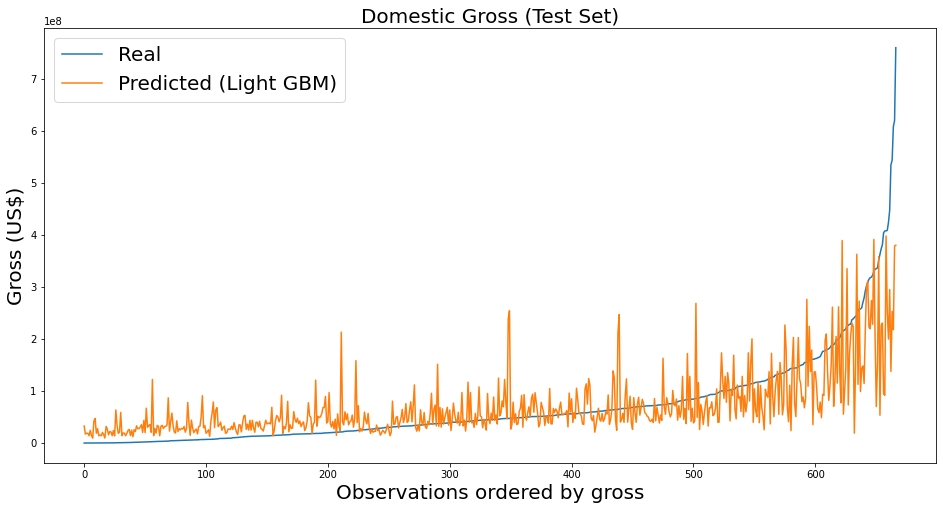

In [54]:
# Plotting predicted values vs real values
y_pred_v3_lgb = lgb_model_cv_gs_v3.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('Domestic Gross (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'LGBM':y_pred_v3_lgb})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Light GBM)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [55]:
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v3_lgb)))

R² Score: 0.532


<br><br>

# Hipótese 4: *tickets_sold*

In [56]:
X, y = filmes_x, filmes_y['tickets_sold']
print("Shape X", X.shape)
print("Shape y", y.shape)

seed=10
X_training, X_test, y_training, y_test = train_test_split(X, y, random_state=seed, test_size=0.25)

print()
print("Training set X", X_training.shape)
print("Training set X", y_training.shape)
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Shape X (2668, 25)
Shape y (2668,)

Training set X (2001, 25)
Training set X (2001,)
Test set X (667, 25)
Test set y (667,)


<br>

## Hip.4: Random Forest

In [27]:
# Random Forest com Cross Validation e Grid Search

# Define os valores possíveis para cada um dos parâmetros a ser testados no Grid Search
params = {'n_estimators': [5, 35, 40, 45, 50, 55, 60],
          'max_features': [14, 15, 16, 17, 18, 19],
          'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 20, 30],
          'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 15, 30],}

# Cria um objeto de modelo usando RandomForestRegressor
rf_model_cv_gs_v4 = RandomForestRegressor()

# Cria um objeto de grid search com usando GridSearchCV
grid_search_v4 = GridSearchCV(rf_model_cv_gs_v4, param_grid=params, scoring='r2', return_train_score=True) #default value for splitting is 3

# Treina o modelo com o grid search
grid_search_v4.fit(X_training, y_training)

# Imprime a melhor combinação de hiperparâmetros identificados na busca
print('\n Best hyperparameters:')
print(grid_search_v4.best_params_)

# Pega cv_results do grid search
cv_results_v4 = pd.DataFrame(grid_search_v4.cv_results_)

# Imprime Score médio nos conjuntos de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v4[cv_results_v4.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v4[cv_results_v4.rank_test_score == 1].std_train_score.values[0]))
# Imprime Score médio nos conjuntos de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v4[cv_results_v4.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v4[cv_results_v4.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'max_depth': 7, 'max_features': 15, 'min_samples_split': 7, 'n_estimators': 40}
Average Score on train set: 0.691 +/- 0.008
Average Score on validation set: 0.486 +/- 0.059


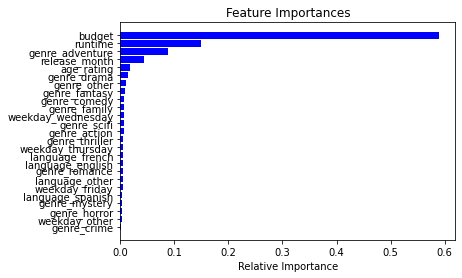

In [28]:
# Define os parâmetros do objeto de modelo para os melhores parâmetros identificados na busca
rf_model_cv_gs_v4.set_params(n_estimators = grid_search_v4.best_params_['n_estimators'],
                           max_features = grid_search_v4.best_params_['max_features'],
                           max_depth = grid_search_v4.best_params_['max_depth'],
                           min_samples_split = grid_search_v4.best_params_['min_samples_split'])


# Treina o modelo usando os melhores parâmetros identificados
rf_model_cv_gs_v4.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = rf_model_cv_gs_v4.feature_importances_
indices = np.argsort(importances)

# Gera gráfico de Feature Importance
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Plotagem de valores previstos vs. valores reais (para avaliar visualmente o modelo)
y_pred_v4 = rf_model_cv_gs_v4.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('Tickets Sold (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'RF':rf_model_cv_gs_v4.predict(X_test)})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Random Forest)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [30]:
# Imprime o Score R-quadrado do conjunto de teste
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v4)))

R² Score: 0.526


<br>

## Hip.4: Light GBM

In [ ]:
# Random Forest com Cross Validation e Grid Search para Light GBM

# Define os valores possíveis para cada hiperparâmetro a ser testado
params = {'max_depth': [2, 5, 10, 30],
          'learning_rate': [0.01, 0.03, 0.1, 0.5],
          'n_estimators': [50, 100, 200, 500],
          'min_child_samples': [5, 20, 50],
          'min_split_gain': [0., 0.5, 1, 5],
          'num_leaves': [31, 20, 40] }

# create model object with LGBMRegressor
lgb_model_cv_gs_v4 = lgb.LGBMRegressor(verbose=-1)

# create grid search object with GridSearchCV
grid_search_v4_lgb = GridSearchCV(lgb_model_cv_gs_v4, param_grid=params, scoring='r2', return_train_score=True)

# train the model with grid search
grid_search_v4_lgb.fit(X_training, y_training)

In [58]:
# Imprime a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search_v4_lgb.best_params_)

# get cv_results
cv_results_v4_lgb = pd.DataFrame(grid_search_v4_lgb.cv_results_)

# print average Score on train sets
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results_v4_lgb[cv_results_v4_lgb.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results_v4_lgb[cv_results_v4_lgb.rank_test_score == 1].std_train_score.values[0]))
# print average Score on validation sets
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results_v4_lgb[cv_results_v4_lgb.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results_v4_lgb[cv_results_v4_lgb.rank_test_score == 1].std_test_score.values[0])) 


 Best hyperparameters:
{'learning_rate': 0.03, 'max_depth': 5, 'min_child_samples': 20, 'min_split_gain': 0.0, 'n_estimators': 100, 'num_leaves': 31}
Average Score on train set: 0.613 +/- 0.008
Average Score on validation set: 0.466 +/- 0.033


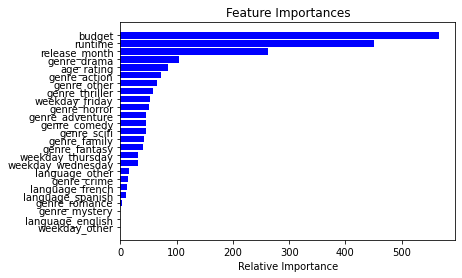

In [59]:
# Define os hiperparâmetros para os melhores identificados
lgb_model_cv_gs_v4.set_params(learning_rate = grid_search_v4_lgb.best_params_['learning_rate'],
                           max_depth = grid_search_v4_lgb.best_params_['max_depth'],
                           min_child_samples = grid_search_v4_lgb.best_params_['min_child_samples'],
                           min_split_gain = grid_search_v4_lgb.best_params_['min_split_gain'],
                           n_estimators = grid_search_v4_lgb.best_params_['n_estimators'],
                           num_leaves = grid_search_v4_lgb.best_params_['num_leaves'])


# train a model using the best parameters
lgb_model_cv_gs_v4.fit(X_training, y_training)

features = np.asarray(filmes_x.columns)
importances = lgb_model_cv_gs_v4.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

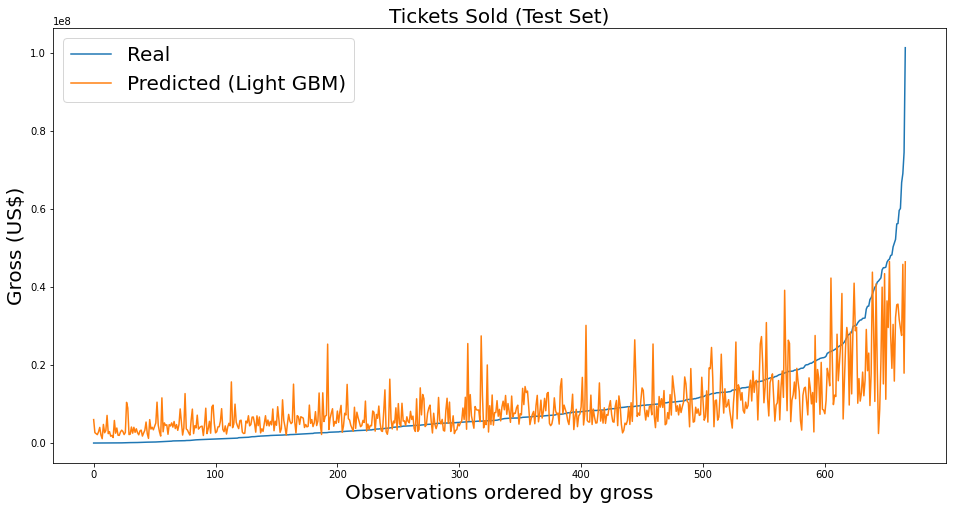

In [60]:
# Plotting predicted values vs real values
y_pred_v4_lgb = lgb_model_cv_gs_v4.predict(X_test)
plt.figure(figsize=(16,8))
plt.title('Tickets Sold (Test Set)',fontsize=20)
df = pd.DataFrame({'real':y_test,'LGBM':y_pred_v4_lgb})
df.sort_values(by=['real'],ascending=True,inplace=True)
df = df.reset_index(drop=True)
plt.plot(df)
plt.legend(['Real','Predicted (Light GBM)'],fontsize=20)
plt.ylabel('Gross (US$)',fontsize=20)
plt.xlabel('Observations ordered by gross',fontsize=20)
plt.show()

In [61]:
print("R² Score: {:.3f}".format(r2_score(y_test, y_pred_v4_lgb)))

R² Score: 0.525
